In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import random 


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/junchishen/miniconda3/envs/dlpm_clean/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/junchishen/miniconda3/envs/dlpm_clean/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/junchishen/miniconda3/envs/dlpm_clean/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/junchishen/miniconda3/envs/dlpm_clean/lib/python3.10/site-packages/t

Define the Unet Model 

# Forward process

## 数据预处理

In [2]:
import pandas as pd 

train_data = pd.read_csv('trainning_data_merged.csv')

## Deal with data 

Ticker 和 asset_underlying 的逻辑是重复的 我们去掉Ticker

In [3]:
train_data.drop(columns=['ticker'], inplace=True)

归一化处理日期

In [4]:
# 1. 合约期限（归一化到年）
# contract_days = train_data['contract_calendar_days'] / 365.0

train_data['contract_calendar_days'] = train_data['contract_calendar_days'] / 365.0

# 2. 实际交易日（归一化到年）
train_data['actual_trading_days'] = train_data['actual_trading_days'] / 252
# trading_days = actual_trading_days / 252

# 3. 交易日比例
# trading_ratio = trading_days / contract_days
train_data['trading_ratio'] = train_data['actual_trading_days'] / train_data['contract_calendar_days']
         

处理 price series: 将 price_series 从字符串（如 "[100, 101, 102]"）解析为 numpy 数组

In [5]:
import torch
import re

def parse_price_series(price_list):
    """
    修复版：正确处理价格序列，避免匹配到单独的 '.'
    """
    # 将所有字符串连接
    combined = ''.join(str(item) for item in price_list)
    
    # 使用更精确的正则表达式：匹配整数或小数
    # \d+\.\d+ 匹配小数（如 6139.29）
    # \d+ 匹配整数（如 100）
    numbers = re.findall(r'\d+\.\d+|\d+', combined)
    
    # 转换为浮点数并创建 tensor
    return torch.tensor([float(n) for n in numbers], dtype=torch.float32)

# 应用到整个列
train_data['price_series'] = train_data['price_series'].apply(parse_price_series)

# 验证
print(f"第一个价格序列: {train_data['price_series'][0]}")
print(f"长度: {len(train_data['price_series'][0])}")

第一个价格序列: tensor([6139.2900, 6168.6602, 6252.0801, 6109.2900, 6336.6299, 6465.7300,
        6568.6401, 6502.0698, 6642.6099, 6693.8101, 6666.2598, 6625.0098,
        6546.6001, 6535.8999, 6654.5498, 6653.3398, 6654.0801, 6526.9502,
        6474.8198, 6555.8198, 6645.5098, 6703.8198, 6815.8501])
长度: 23


把start_price column的名字 改为 S_0

In [6]:
train_data.rename(columns={'start_price': 'S_0'}, inplace=True)

获取对数收益率

Demo 逻辑

In [7]:
# log_returns = torch.diff(torch.log(train_data['price_series'][1]))
# # 收益率会减少一位
# print(log_returns)

# scaled_returns = log_returns

# # 创建固定长度序列
# target = torch.zeros(252)
# mask = torch.zeros(252)

# # 设置起始标记
# target[0] = 1.0
# mask[0] = 1.0

# # 填充收益率（最多251个）
# num_to_fill = min(len(scaled_returns), 251)
# target[1:1 + num_to_fill] = scaled_returns[:num_to_fill]
# mask[1:1 + num_to_fill] = 1.0

# # 保存
# mask,target

In [8]:
def process_multiple_rows(price_series_column, max_length=252):
    """
    处理多行价格序列数据
    
    参数:
        price_series_column: pandas Series，包含多个价格序列（tensor）
        max_length: 目标序列长度，默认252
    
    返回:
        targets: 形状为 (n_samples, max_length) 的 tensor
        masks: 形状为 (n_samples, max_length) 的 tensor
    """
    n_samples = len(price_series_column)
    targets = torch.zeros(n_samples, max_length)
    masks = torch.zeros(n_samples, max_length)
    
    for i in range(n_samples):
        # 获取第 i 行的价格序列
        price_seq = price_series_column.iloc[i]
        
        # 计算对数收益率
        log_returns = torch.diff(torch.log(price_seq))
        
        # 设置起始标记
        targets[i, 0] = 1.0
        masks[i, 0] = 1.0
        
        # 填充收益率（最多 max_length-1 个）
        num_to_fill = min(len(log_returns), max_length - 1)
        targets[i, 1:1 + num_to_fill] = log_returns[:num_to_fill]
        masks[i, 1:1 + num_to_fill] = 1.0
    
    return targets, masks

# 使用示例
targets, masks = process_multiple_rows(train_data['price_series'])
print(f"targets 形状: {targets.shape}")
print(f"masks 形状: {masks.shape}")

targets 形状: torch.Size([65496, 252])
masks 形状: torch.Size([65496, 252])


Using embedding to achieve ticker_id

In [9]:
unique_tickers = sorted(train_data["asset_underlying"].unique())

ticker2id = {t: i for i, t in enumerate(unique_tickers)}
id2ticker = {i: t for t, i in ticker2id.items()}  # 可选：反向映射

# 3. 在 df 中新增一列 ticker_id
train_data["asset_underlying_id"] = train_data["asset_underlying"].map(ticker2id).astype("int64")
train_data.drop(columns=['asset_underlying'], inplace=True)

one-hot country as 0 and 1

In [10]:
train_data["country"] = train_data["country"].map({"USA": 0, "China": 1})

综合数据情况

In [11]:
X_train = train_data.drop(columns=['price_series', 'start_date','expected_trading_days','actual_trading_days'])

# trading_ratio 是需要的， contract_calendar_days是需要的
y_train = targets
X_train.head()

## Add noise 

,contract_calendar_days,S_0,volatility,risk_free_rate,country,trading_ratio,asset_underlying_id
0,0.082192,6139.29,0.212546,0.047990,1,1.062169,0
1,0.082192,6168.66,0.212604,0.047970,1,1.013889,0
2,0.082192,6252.08,0.210737,0.047930,1,0.965608,0
3,0.082192,6109.29,0.210879,0.047900,1,1.013889,0
4,0.082192,6336.63,0.212102,0.048465,1,0.965608,0


In [12]:
y_train

tensor([[ 1.0000e+00,  4.7722e-03,  1.3433e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  1.3433e-02, -2.3104e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -2.3104e-02,  3.6537e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 1.0000e+00,  9.5148e-03, -4.1008e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -4.1008e-04, -2.6302e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00, -2.6302e-03, -1.2024e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

## 数据后处理

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("需要缩放的数值列:", numeric_cols)
scaler = RobustScaler()

cols_to_scale = ['S_0', 'contract_calendar_days', 'trading_ratio']

X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

print("缩放完成")
print(X_train_scaled[cols_to_scale].describe())

import joblib
# 保存 scaler，用于推理时转换新数据
joblib.dump(scaler, 'scaler.pkl')

需要缩放的数值列: ['contract_calendar_days', 'S_0', 'volatility', 'risk_free_rate', 'country', 'trading_ratio', 'asset_underlying_id']
缩放完成
                S_0  contract_calendar_days  trading_ratio
count  65496.000000            65496.000000   65496.000000
mean       0.610168                0.456162      -0.270683
std        1.774755                0.826237       1.292925
min       -0.885059               -0.400000     -10.138889
25%       -0.399929               -0.400000      -0.712963
50%        0.000000                0.000000       0.000000
75%        0.600071                0.600000       0.287037
max        7.339885                1.833333       2.027778


['scaler.pkl']

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

# 转换为 numpy
X_array = X_train_scaled.to_numpy()

# 使用 tolist() 方法（最可靠，适用于所有情况）
print("正在转换 targets...")
y_array = np.array(targets.tolist(), dtype=np.float32)

print("正在转换 masks...")
mask_array = np.array(masks.tolist(), dtype=np.float32)

print(f"转换完成！y_array 形状: {y_array.shape}, mask_array 形状: {mask_array.shape}")

# 数据分割
X_train_split, X_val_split, y_train_split, y_val_split, mask_train, mask_val = train_test_split(
    X_array, y_array, mask_array,
    test_size=0.2,
    random_state=42
)

print(f"\n数据分割完成:")
print(f"训练集大小: {len(X_train_split)}")
print(f"验证集大小: {len(X_val_split)}")

正在转换 targets...
正在转换 masks...
转换完成！y_array 形状: (65496, 252), mask_array 形状: (65496, 252)

数据分割完成:
训练集大小: 52396
验证集大小: 13100


数据分割地方有个小Bug 应该根据时间分割 但是没做这一步 后面看看效果再说

In [15]:
class PriceSeriesDataset(Dataset):
    def __init__(self, X, y, mask):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            'X': self.X[idx],
            'y': self.y[idx],
            'mask': self.mask[idx]
        }

# 创建数据集
train_dataset = PriceSeriesDataset(X_train_split, y_train_split, mask_train)
val_dataset = PriceSeriesDataset(X_val_split, y_val_split, mask_val)

# 创建 DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoader 创建完成")

DataLoader 创建完成


# Building models


## Add noise 

Randomize 高斯噪音: $G_t$, 重尾因子 $S_{\alpha}$ 以及一个 时间步 $t$

In [ ]:

T = 4000
t = random.randint(0, T)

def generate_noises(dim, alpha, size=1):
    """
    dim: 数据的维度 (例如图像的通道*高*宽)
    alpha: 尾部指数 (1 < alpha < 2)
    """
    # 1. 生成标准高斯噪音 (Gaussian Noise)
    # 在 DLPM 中对应 G_t [cite: 108, 559]
    gaussian_noise = np.random.normal(0, 1, (size, dim))
    
    # 2. 生成正稳定分布因子 (Positive Stable Variable A)
    # 对应论文中的 A ~ S_{alpha/2, 1}(0, c_A) [cite: 108, 559]
    # 使用 CMS 采样方法
    def sample_positive_stable(a_val, num_samples):
        # 这里的 a_val 对应论文中的 alpha/2 [cite: 108, 112]
        half_alpha = a_val / 2
        U = np.random.uniform(-np.pi/2, np.pi/2, num_samples)
        W = np.random.exponential(1, num_samples)
        
        # 核心 CMS 公式
        term1 = np.sin(half_alpha * (U + np.pi/2)) / (np.cos(U)**(1/half_alpha))
        term2 = (np.cos(U - half_alpha * (U + np.pi/2)) / W)**((1 - half_alpha) / half_alpha)
        A = (term1 * term2)
        
        # 乘以尺度常数 c_A = cos^{2/alpha}(pi * alpha / 4) [cite: 108, 552]
        c_A = np.cos(np.pi * a_val / 4)**(1 / half_alpha)
        return A * c_A

    A_t = sample_positive_stable(alpha, size)
    
    # 3. 合成 DLPM 特有的重尾噪音
    # epsilon = sqrt(A) * G 
    heavy_tailed_noise = np.sqrt(A_t)[:, np.newaxis] * gaussian_noise
    
    return gaussian_noise, A_t, heavy_tailed_noise

# 示例：alpha=1.7 (论文中常用的值) [cite: 242, 402]
alpha = 1.
g_noise, a_factor, ht_noise = generate_noises(dim=252, alpha = alpha)
# 其中的ht_noise 就是最后我们需要的噪音 


Plot the noise if necessary 

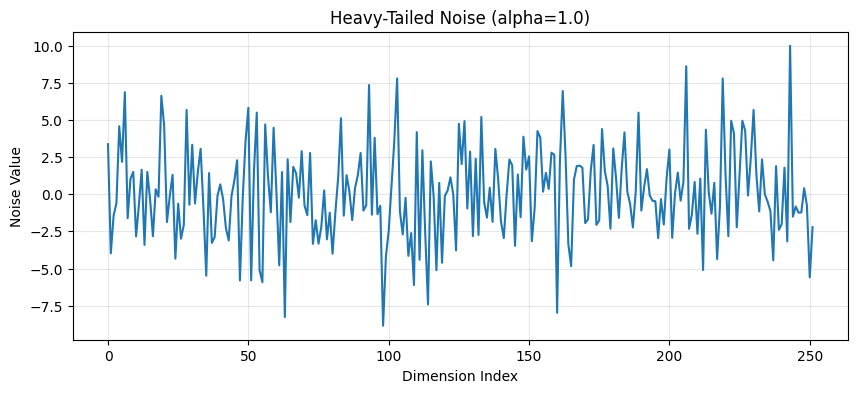

ht_noise 形状: (1, 252)
均值: 0.0930
标准差: 3.1396
最小值: -8.8473
最大值: 9.9864


In [17]:
# plot the noise
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(ht_noise[0])  # 取第一行（因为 size=1）
plt.xlabel('Dimension Index')
plt.ylabel('Noise Value')
plt.title(f'Heavy-Tailed Noise (alpha={alpha})')
plt.grid(True, alpha=0.3)
plt.show()

# 也可以打印一些统计信息
print(f"ht_noise 形状: {ht_noise.shape}")
print(f"均值: {ht_noise.mean():.4f}")
print(f"标准差: {ht_noise.std():.4f}")
print(f"最小值: {ht_noise.min():.4f}")
print(f"最大值: {ht_noise.max():.4f}")

# Training process

## Cosine scheduler (input = T, t, $\alpha$) = (output = $\gamma_{1\rightarrow t}$, $\sigma_{1\rightarrow t}$)

这个里面对应的 T 指的是总的时间步骤，alpha 决定噪声的“重尾”程度。当 $\alpha$ 越小（如 1.5），产生的噪声中偶尔会出现极大的“跳跃”值。 

$t$ 决定了公式里 $\gamma_{1\rightarrow t}$ 和 $\sigma_{1\rightarrow t}$ 到底取数组里的哪一个数

In [18]:
alpha = 1.7

In [19]:
def get_dlpm_cosine_schedule(T, alpha, s=0.008):
    """
    T: 总时间步 (Total time steps)
    alpha: 尾部指数 (Tail index, 1 < alpha <= 2)
    s: 偏移量，防止 t=0 时噪声过大
    """
    # 1. 定义时间步序列
    steps = np.arange(T + 1)
    
    # 2. 计算累积比例函数 f(t) [余弦曲线核心]
    # 使用余弦平方函数，确保加噪过程平滑
    ft = np.cos(((steps / T) + s) / (1 + s) * (np.pi / 2))**2
    
    # 3. 计算累积噪声控制序列 alpha_bar (在 DLPM 中对应缩放逻辑)
    # alpha_bar 决定了原始信号保留的比例
    alphas_bar = ft / ft[0]
    
    # 4. 根据 alpha_bar 计算 DLPM 特有的调度参数
    # gamma_1_to_t: 位置/衰减系数 (控制原始数据 Y0 保留比例)
    gamma_1_to_t = (alphas_bar)**(1 / alpha)
    
    # sigma_1_to_t: 尺度/噪声系数 (控制注入重尾噪声的强度)
    # 基于尺度保持原则: gamma^alpha + sigma^alpha = 1
    sigma_1_to_t = (1 - alphas_bar)**(1 / alpha)
    
    return gamma_1_to_t[1:], sigma_1_to_t[1:]

# 使用示例 当t为1000时
T = 1000

# 我们获取对应的$\gamma_{1\rightarrow t}$ 和 $\sigma_{1\rightarrow t}$ 
gamma_bar, sigma_bar = get_dlpm_cosine_schedule(T, alpha)
# 这个里面的的下标 对应的是不同的t

在你的函数返回 gamma_1_to_t[1:] 后：\
gamma_bar[0] 对应的是 $t=1$ 时的 $\gamma_{1 \to 1}$。 \
gamma_bar[19] 对应的是 $t=20$ 时的 $\gamma_{1 \to 20}$。 

注意：如果你想直接用 gamma_bar[20] 获取 $t=20$ 的值，你需要确保数组长度足够（即 steps 是 T+1 且不切片，或者在调用时意识到索引偏移了 1 位）。‘

In [20]:
gamma_bar[20]

np.float64(0.9988902916904095)

Get $Y_t$ with formula: 

$Y_t = \gamma_{1\rightarrow t}Y_0 + \sigma_{1\rightarrow t}\overline{A}_t^{1/2}G_t$ 

In [21]:


def sample_positive_stable(alpha, batch_size, device='cpu'):
    """
    手动实现正稳定分布采样 S_{alpha/2, 1}(0, c_A)
    """
    alpha_s = alpha / 2
    # 1. 采样辅助变量 U ~ Uniform(-pi/2, pi/2) 和 W ~ Exponential(1)
    U = (torch.rand(batch_size, device=device) - 0.5) * np.pi
    W = -torch.log(torch.rand(batch_size, device=device))
    
    # 2. 计算尺度参数 c_A
    c_A = np.cos(np.pi * alpha / 4)**(2 / alpha)
    
    # 3. CMS 算法核心变换 (针对 beta=1 的简化公式)
    # 这里的 phi 是相位偏移量
    phi = np.pi / 2 
    
    # 计算变换公式
    part1 = torch.sin(alpha_s * (phi + U)) / (torch.cos(U)**(1/alpha_s))
    part2 = (torch.cos(U - alpha_s * (phi + U)) / W)**((1 - alpha_s) / alpha_s)
    
    A = part1 * part2
    
    # 乘以尺度参数 c_A
    return A * c_A


A_samples = sample_positive_stable(alpha, batch_size=1)
A_half = torch.sqrt(A_samples) # 得到公式中的 \overline{A}_t^{1/2}

In [22]:
def get_Y_t(Y_0, t, gamma_bar, sigma_bar, noise, A_half):
    # noise 对应公式中的 G_t（标准高斯噪声）
    # A_half 对应公式中的 \overline{A}_t^{1/2}
    # 替换后的公式实现了重尾噪声的注入
    return gamma_bar[t] * Y_0 + sigma_bar[t] * (A_half * noise)

In [26]:
# get final Y_t

Y_0 = targets
Y_t = get_Y_t(Y_0, t, gamma_bar[t], sigma_bar[t],g_noise, A_half)

IndexError: index 3968 is out of bounds for axis 0 with size 1000

Define loss function

In [ ]:
error = model(Y_t, t) - g_noise * A_half
mse = torch.mean(error**2)
loss = torch.sqrt(mse)

loss.backward()